In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import prepState
from numpy import linalg as LA
from numpy import log as ln
from timeEvo import *
from qutip import *

# for using tex formatting and font in plots
#"""
plt.rcParams.update({"text.usetex": True,}) 
plt.rcParams['text.latex.preamble'] = r'\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{lmodern}\inputencoding{utf8}\usepackage{amsmath}\usepackage{amssymb}\usepackage{dsfont}\usepackage{mathtools}\usepackage{physics}'
mpl.rc('font', **{'family':'sans-serif', 'size':11})
cmap = mpl.cm.get_cmap('viridis')#['viridis', 'plasma', 'inferno', 'magma', 'cividis']
#"""

In [2]:
## a lot of functions
#
def thermal_state(beta):
    rho = (-beta *sigmaz()).expm()
    Z = rho.tr()
    rho = rho/Z
    return rho


def timeEvo(dt, rho, Hint): # time evolution of an operator rho, SE approach as opposed to me approach
	U = (-1.j * Hint * dt).expm()
	Ud = (1.j * Hint * dt).expm()
	rho = rho * Ud
	return U * rho


def initSystem(first_second_state, N):
	rhoSystem = first_second_state #+ alpha * tensor(Qobj([[0,1],[0,0]]), Qobj([[0,0],[1,0]])) + astar * tensor(Qobj([[0,0],[1,0]]), Qobj([[0,1],[0,0]]))
	for i in range(1,N):
		rhoSystem = tensor(rhoSystem, Qobj([[0,0],[0,1]]))
	return rhoSystem

def writetxt(filename, quantity):
    quantity = np.real(quantity)
    with open(str(filename) + ".txt", "w") as f:
        for element in quantity:
            f.write(str(element) + '\n')

            
def integrate(N, psi0, tlist, solver, interaction):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N+1):
        op_list = [si for m in range(N+1)]

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = generateStates(N, interaction)

    # energy splitting terms

    # interaction terms
    

    # collapse operators
    c_op_list = []


    # evolve and calculate expectation values
    if solver == "me":
        result = mesolve(H, psi0, tlist, c_op_list, sz_list)
    elif solver == "mc":
        ntraj = 250 
        result = mcsolve(H, psi0, tlist, c_op_list, sz_list, ntraj)
    return result.expect


In [3]:
## define constants
#
cm = 1/2.54
N=4
betas = np.insert(np.logspace(-.3,ln(2)/ln(10), 4, endpoint=False), 0, 1/300)
betaOne = betas[-1]
betaTwo = betas[1]
beta = 1
hbar = ln(2)**2

#alpha = 1.j * .25 * 1/(np.cosh(beta))**2
#astar = -alpha
n = 3200
dt = 1e-3
t = np.linspace(0, n*dt, n)

In [4]:
## initiate States

thermal_states = [thermal_state(betaOne), thermal_state(betaTwo), thermal_state(beta)]

alpha = 1.j / (4*np.cosh(betaOne)*np.cosh(betaTwo))
chi = alpha * tensor(Qobj([[0,1],[0,0]]), Qobj([[0,0],[1,0]])) - alpha * tensor(Qobj([[0,0],[1,0]]), Qobj([[0,1],[0,0]]))

corr_state = tensor(thermal_states[0], thermal_states[1]) + chi
corr_state_fail = tensor(thermal_states[0], thermal_states[1]) + (np.exp(-(betaOne+betaTwo)/2))*chi
corr_state_low = tensor(thermal_states[0], thermal_states[1]) + (np.exp(-(betaOne+betaTwo)*5))*chi
bell_states = bell_state('11')*bell_state('11').dag()

print(corr_state.eigenenergies(), alpha)
print()
print(corr_state_fail.eigenenergies(), alpha*np.exp((-betaOne-betaTwo)/2))
print()
print(corr_state_low.eigenenergies(), alpha*np.exp((-betaOne-betaTwo)*5))

first_state = Qobj([[1,0],[0,0]])
second_state = Qobj([[0,0],[0,1]])
third_state = Qobj([[0,0],[0,1]])
fourth_state = Qobj([[0,0],[0,1]])
fifth_state = Qobj([[0,0],[0,1]])

corr_system_fail = tensor(corr_state_fail, third_state, fourth_state, fifth_state)      # old alpha
corr_system_low = tensor(corr_state_low, third_state, fourth_state, fifth_state)      # old alpha

rho_system = tensor(thermal_states[0], second_state, third_state, fourth_state, fifth_state)  # general system, no correlations
bell_system = tensor(bell_states, third_state, fourth_state, fifth_state)               # entangled first two qubits
corr_12_system = tensor(corr_state, third_state, fourth_state, fifth_state)             # thermal correlations between 1 and 2
corr_23_system = tensor(first_state, corr_state, fourth_state, fifth_state)             # thermal correlations between 2 and 3
corr_34_system = tensor(first_state, second_state, corr_state, fifth_state)             # thermal correlations between 3 and 4
corr_45_system = tensor(first_state, second_state, third_state, corr_state)             # thermal correlations between 4 and 5

corr_systems = [corr_12_system, corr_system_fail, corr_system_low]#[corr_12_system, corr_23_system, corr_34_system, corr_45_system]         # all correlated systems, for better computing

H_hom = generateStates(N, "hom")
H_perf = generateStates(N, "perf")
H_long = generateStates(N, "long-range")

[-6.93889390e-18  1.49591201e-02  2.94275481e-01  6.90765399e-01] 0.10165255812805006j

[0.01495912 0.03383767 0.26043781 0.6907654 ] 0.03899529237706969j

[0.01495912 0.04075977 0.25351571 0.6907654 ] 7.0154736609091075e-06j


In [10]:
## veryfirstplotsxdd
#
#i = -1
##hmm = [2007, 2008]
#pos=1
#cm=1
#for corr_system in corr_systems:
#pos=pos+11

sz = integrate(N, rho_system, t, "me", "perf")

#fig, ax = plt.subplots(figsize=(14*cm,63*cm/8))

#for n in range(N+1):
#    ax.plot(t, sz[n], label=r"$\expval{\sigma^z_{%d}}$"%(n+1), lw=1.5, color=cmap((n+1)/(N+2)))
#ax.axhline(0,color='grey', ls='--')
#ax.axhline(sz[0][0], color='grey', ls='--')
#ax.axvline(np.pi, color='grey', ls=':')
#ax.set_xlabel(r'Time')
#ax.set_ylabel(r'$\expval{\sigma^z_i}$')
#
#
#fig.legend(loc=7)
    #fig.tight_layout()
    #fig.subplots_adjust(right=.78)
    #plt.savefig("alltheplots/diff_beta/beta1>>beta2/"+str(pos)+"_expval_z.pdf")

In [9]:
## calculate time evolution
t=np.linspace(0,3.2,3200)
perf_evo = qutip.mesolve(H_perf, rho_system, t, [], []).states
bell_evo = qutip.mesolve(H_perf, bell_system, t, [], []).states
corr_evo12 = qutip.mesolve(H_perf, corr_12_system, t, [], []).states
corr_evo23 = qutip.mesolve(H_perf, corr_23_system, t, [], []).states
corr_evo34 = qutip.mesolve(H_perf, corr_34_system, t, [], []).states
corr_evo45 = qutip.mesolve(H_perf, corr_45_system, t, [], []).states

corr_evo_list = [corr_evo12, corr_evo23, corr_evo34, corr_evo45]

#t=np.linspace(0,2,2000)
#hom_evo = qutip.mesolve(H_hom, rho_system, t, [], []).states
#t=np.linspace(0,5,5000)
#long_evo = qutip.mesolve(H_long, rho_system, t, [], []).states

In [11]:
## quantities for perfect transfer

t=np.linspace(0,3.2,3200)

#fid_perf  = [fidelity(rho_system.ptrace(0), perf_evo[dt].ptrace(N)) for dt in range(len(t))]
#dkl_perf  = [entropy_relative(rho_system.ptrace(0), perf_evo[dt].ptrace(N)) for dt in range(len(t))]
#
#max_value = max(fid_perf)
#max_index = fid_perf.index(max_value)

#print(max_value, max_index)

vn_perf = [entropy_vn(perf_evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
#dkl_perf = [entropy_relative(perf_evo[dt].ptrace(N), fifth_state) for dt in range(len(t))]
#dkl_dot_perf = np.diff(dkl_perf)/(dt)
#i_dot_perf = np.diff(vn_perf)/dt
i_dot_sq_perf = np.square(np.diff(vn_perf)/dt)
e_dot = np.pi * np.diff(sz[-1])/(3*dt)
#pendrybound_perf = [-1.j *(np.pi/(3)) * (commutator(H_perf, perf_evo[dt]).ptrace(N) * (sigmaz())).tr() for dt in range(len(t))]

#writetxt("txtfiles/j_var/fidelity", fid_perf)
#writetxt("txtfiles/j_var/dkl", dkl_perf)
#writetxt("txtfiles/j_var/infoflow", i_dot_sq_perf)
#writetxt("txtfiles/j_var/pendrybound", np.real(pendrybound_perf))
#writetxt("txtfiles/j_var/maxfid", [max_value, max_index])

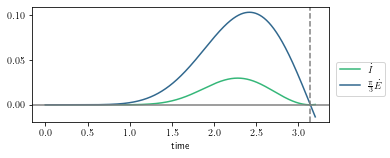

In [23]:
cm=1/2.54
fig, ax = plt.subplots(figsize=(14*cm,35*cm/6))

ax.plot(t[:-1], i_dot_sq_perf, label=r'$\dot{I}$', color=cmap(2/3))
ax.plot(t[:-1], e_dot, label=r'$\frac{\pi}{3}\dot{E}$', color=cmap(1/3))
ax.set_xlabel(r"time")
ax.axhline(0, color='grey')
ax.axvline(np.pi, color='grey', ls='--')
fig.tight_layout()
fig.subplots_adjust(right=.85)
fig.legend(loc=7)
plt.savefig("pendry_propagate_thermal_state_energy_without_ln2.pdf")

In [65]:
## quantities for long range interaction

fid_long  = [fidelity(first_state, long_evo[dt].ptrace(N)) for dt in range(len(t))]
dkl_long  = [entropy_relative(first_state, long_evo[dt].ptrace(N)) for dt in range(len(t))]

max_value_long = max(fid_long)
max_value_long_2 = max(fid_long[:3000])
max_index_long = fid_long.index(max_value_long)
max_index_long_2 = fid_long.index(max_value_long_2)
print(max_value_long, max_index_long)
print()
print(max_value_long_2, max_index_long_2)


vn_long = [entropy_vn(long_evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
i_dot_sq_long = np.square(np.diff(vn_long)/dt)
pendrybound_long = [-1.j *(np.pi/(3*hbar)) * (commutator(H_long, long_evo[dt]).ptrace(N) * (sigmaz())).tr() for dt in range(len(t))]

writetxt("txtfiles/longrange/fidelity", fid_long)
writetxt("txtfiles/longrange/kld", dkl_long)
writetxt("txtfiles/longrange/infoflow", i_dot_sq_long)
writetxt("txtfiles/longrange/pendrybound", pendrybound_long)
writetxt("txtfiles/longrange/maxfid", [max_value_long, max_index_long, max_value_long_2, max_index_long_2])

0.8430555166626655 4419

0.49984807813553067 2427


In [73]:
## quantities for correlation plots
t=np.linspace(0,3.2,3200)
i=1
for corr_evo in corr_evo_list:
    i = i+11
    
    #for fid/dkl plots
    
    fid_corr  = [fidelity(corr_evo[0].ptrace(0), corr_evo[dt].ptrace(N)) for dt in range(len(t))]
    dkl_corr_plots  = [entropy_relative(corr_evo[0].ptrace(0), corr_evo[dt].ptrace(N)) for dt in range(len(t))]
    
    dkl_corr = [entropy_relative(corr_evo[dt].ptrace(N), thermal_state(1)) for dt in range(len(t))]
    dkl_dot_corr = np.diff(dkl_corr)/(dt)
    heatflow_corr = [-1.j * (commutator(H_perf, corr_evo[dt]).ptrace(N) * (sigmaz())).tr() for dt in range(len(t))]
    
    vn_corr = [entropy_vn(corr_evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
    i_dot_sq_corr = np.square(np.diff(vn_corr)/dt)#(np.pi/(3*hbar))
    
    pendry_corr = [(np.pi/(3*hbar)) * np.real(heatflow_corr[dt]) for dt in range(len(heatflow_corr))]
#
    writetxt("txtfiles/diff_beta/beta1>>beta2/"+str(i)+"_fidelity", fid_corr)
    writetxt("txtfiles/diff_beta/beta1>>beta2/"+str(i)+"_kld", dkl_corr_plots)
    writetxt("txtfiles/diff_beta/beta1>>beta2/"+str(i)+"_infoflow", i_dot_sq_corr)
    writetxt("txtfiles/diff_beta/beta1>>beta2/"+str(i)+"_pendry", pendry_corr)
    writetxt("txtfiles/newbound/"+str(i)+"_corr_edot_diff_beta_beta1>>beta2-newalpha", np.real(heatflow_corr))
    writetxt("txtfiles/newbound/"+str(i)+"_corr_dkldot_diff_beta_beta1>>beta2-newalpha", dkl_dot_corr)


In [144]:
## new bound system setup

t = np.linspace(0,3.2,3200)
beta1 = 1/300
beta2 = 1/300
beta_here = 0
alpha = 1.j / (4*np.cosh(beta1)*np.cosh(beta2))
chi = alpha * tensor(Qobj([[0,1],[0,0]]), Qobj([[0,0],[1,0]])) - alpha * tensor(Qobj([[0,0],[1,0]]), Qobj([[0,1],[0,0]]))

first_second_state = tensor(thermal_state(beta1), thermal_state(beta2))
corr_state = first_second_state + chi
excited_state = Qobj([[1,0],[0,0]])
ground_state = Qobj([[0,0],[0,1]])
fifth_state = thermal_state(beta_here)
print(fifth_state)

newbound_system_perf = tensor(first_second_state, ground_state, ground_state, ground_state)
newbound_system_corr = tensor(corr_state, ground_state, ground_state, ground_state)

newbound_perf_evo = qutip.mesolve(H_perf, newbound_system_perf, t, [], []).states
newbound_corr_evo = qutip.mesolve(H_perf, newbound_system_corr, t, [], []).states

print(corr_state.eigenenergies())


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0. ]
 [0.  0.5]]
[9.71445147e-17 2.48336117e-01 2.51669438e-01 4.99994444e-01]


In [145]:
## compute quantities

# uncorrelated

vn_perf = np.real([entropy_vn(newbound_perf_evo[dt].ptrace(N), base=np.e) for dt in range(len(t))])
dkl_perf = np.real([entropy_relative(newbound_perf_evo[dt].ptrace(N), fifth_state) for dt in range(len(t))])
dkl_dot_perf = np.diff(dkl_perf)/(dt)
i_dot_perf = np.diff(vn_perf)/dt
i_dot_sq_perf = np.square(np.diff(vn_perf)/dt)
pendrybound_perf = np.real([-1.j *(np.pi/(3*hbar)) * (commutator(H_perf, newbound_perf_evo[dt]).ptrace(N) * (sigmaz())).tr() for dt in range(len(t))])

print("done!")

# correlated

#heatflow_corr = np.loadtxt("txtfiles/newbound/12_corr_edot.txt")
#dkl_dot_corr = np.loadtxt("txtfiles/newbound/12_corr_dkldot.txt")
dkl_corr = np.real([entropy_relative(newbound_corr_evo[dt].ptrace(N), fifth_state) for dt in range(len(t))])
dkl_dot_corr = np.diff(dkl_corr)/(dt)
heatflow_corr = np.real([-1.j * beta_here * (commutator(H_perf, newbound_corr_evo[dt]).ptrace(N) * (sigmaz())).tr() for dt in range(len(t))])
vn_corr = np.real([entropy_vn(newbound_corr_evo[dt].ptrace(N), base=np.e) for dt in range(len(t))])
i_dot_corr = np.diff(vn_corr)/dt
i_dot_sq_corr = np.square(np.diff(vn_corr)/dt)

done!


In [146]:
# compute new bound
t=np.linspace(0,3.2,3200)
from scipy.linalg import logm


def new_rel_ent(rho, sigma):
    rho, sigma = np.array(rho), np.array(sigma)
    kld = rho * logm(rho) - rho * logm(sigma)
    kld = Qobj(kld)
    return kld.tr()


    


delta_dkl_chi = [dkl_dot_corr[dt] - dkl_dot_perf[dt] for dt in range(len(t)-1)]
squared_terms = [pendrybound_perf[dt] + heatflow_corr[dt]**2 + delta_dkl_chi[dt]**2 for dt in range(len(t)-1)]

simpler = [i_dot_sq_corr[dt] - i_dot_sq_perf[dt] + pendrybound_perf[dt] for dt in range(len(t)-1)]

newbound = [(squared_terms[dt] + 2*heatflow_corr[dt]*i_dot_perf[dt] - 2 * heatflow_corr[dt] * delta_dkl_chi[dt] - 2*i_dot_perf[dt]*delta_dkl_chi[dt]) for dt in range(len(t)-1)]

newbound_test = [pendrybound_perf[dt] + (beta_here*heatflow_corr[dt] - delta_dkl_chi[dt])**2 + 2*i_dot_perf[dt]*(beta_here*heatflow_corr[dt] - delta_dkl_chi[dt]) for dt in range(len(t)-1)]


#rip = pendrybound_perf[dt] + 
#print(fidelity(fifth_state, ground_state), min(newbound), max(newbound))

#writetxt("txtfiles/newbound/newbound/12_corr_beta1=beta2_simpler", simpler)
#writetxt("txtfiles/newbound/newbound/12_corr_beta1=beta2_newbound", newbound)
#writetxt("txtfiles/newbound/newbound/12_corr_beta1=beta2_info", i_dot_sq_corr)

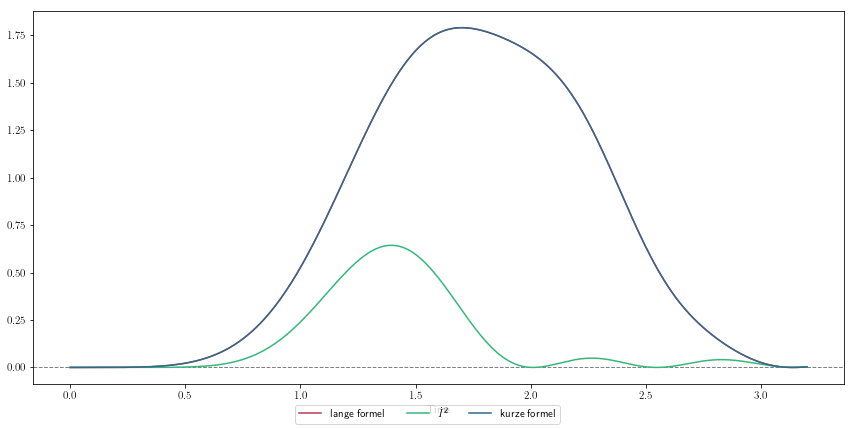

In [152]:
#t=np.linspace(0,3.2,3198)

fig, axs1= plt.subplots(figsize=(12,6))
t=np.linspace(0,3.2,3199)
axs1.axhline(0, color="grey", ls='--', linewidth=1)
axs1.plot(t, newbound, label=r'lange formel', color=mpl.cm.get_cmap('inferno')(1/2), ls='-')
axs1.plot(t, i_dot_sq_corr, label=r"$\dot{I}^2$", color=cmap(2/3), ls='-')
axs1.plot(t, simpler, label=r"kurze formel", color=cmap(1/3), ls='-')
#axs1.plot(t, newbound_test, label=r"mittel lange formel", color = mpl.cm.get_cmap('cividis')(1/3), ls=(0,(5,1.5)), lw=1)
#axs1.plot(t[4:-4], ratio[4:-4], label=r"ratio", color = mpl.cm.get_cmap('cividis')(1/3), ls=(0,(5,1.5)), lw=1)
#axs1.axvline(max_index_long*1e-3,color='grey', ls=':',linewidth=1)
#axs1.axvline(np.pi, color='grey', ls=':', linewidth=1)
#axs1.axvline(long_list[-1][1]*1e-3, color='grey', ls=':', linewidth=1)

#axs1.plot(t, oldbound, label=r"old bound", color=cmap(1))
#axs1.set_ylim(-2,15)
#axs1.set_xlim(2.5, 2.65)
axs1.set_xlabel(r'Time')
#axs1.set_xlim()
fig.legend(loc=8, ncol=3)
fig.tight_layout()
#fig.subplots_adjust(bottom=.32)

In [ ]:
## quantities for correlations correction
this_beta = 1
fifth_state = thermal_state(this_beta)
print(fidelity(fifth_state, fourth_state))

#this_beta = 10

dkl_corr = [entropy_relative(corr_evo[dt].ptrace(N), fifth_state) for dt in range(len(t))]
dkl_dot_corr = np.diff(dkl_corr)/(dt)

heatflow_corr = [-1.j * this_beta * (commutator(H_perf, corr_evo[dt]).ptrace(N) * (sigmaz())).tr() for dt in range(len(t))]


oldbound = [-1.j * (np.pi/(3*hbar)) * (commutator(H_perf, corr_evo[dt]).ptrace(N) * (sigmaz())).tr() for dt in range(len(t))]

0.9385078997951388


In [ ]:
## comment cemetery
#extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#print(bell_states, tensor(first_state, second_state), fifth_state, ln(fidelity(fifth_state, fourth_state)))#0.5 * 1j * 1/np.sqrt(((-betaOne * sigmaz()).expm().tr())*((-betaTwo * sigmaz()).expm().tr())) * np.sinh(betaOne - betaTwo) #
#min(-3,4)
#list = [0,-6,1,2,3,4,5,6,7,8,-9]
#list[:8]

[0, -6, 1, 2, 3, 4, 5, 6]